shape of A: (2961, 2961)
Execution time: 0.12965965270996094
Space dimension: 90
H∞ norm: 24.132299660012137


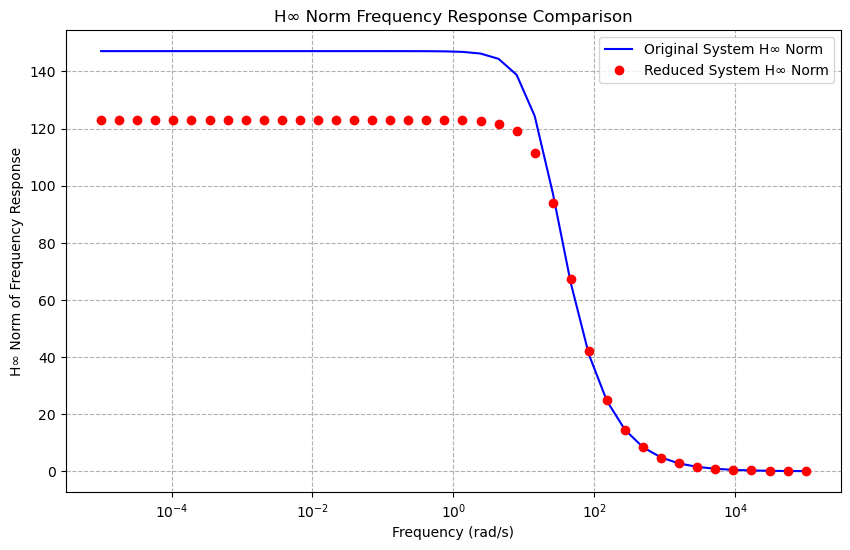

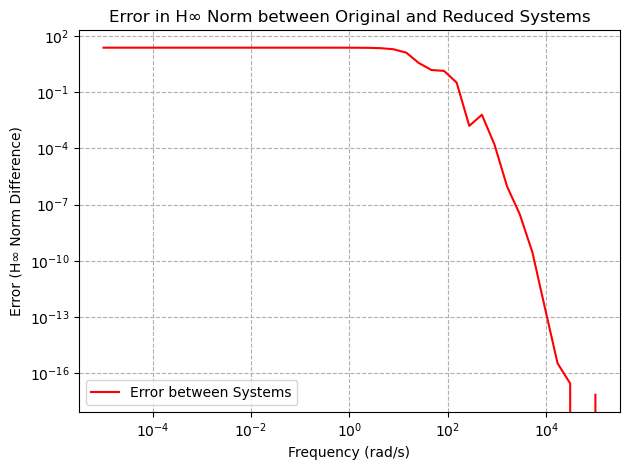

In [5]:
import numpy as np
from scipy.linalg import solve
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import mmread 
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds, LinearOperator, aslinearoperator
from scipy.sparse import eye, linalg as splinalg
import scipy.sparse as sps
from numerical_test1 import fdm_matrix1
from scipy.linalg import svdvals
from build_matrix_A import build_matrix_A
import time

def block_arnoldi(A, B, m):
    n, p = B.shape
    V = np.zeros((n, (m+1)*p), dtype=A.dtype)
    H = np.zeros(((m+1)*p, m*p), dtype=A.dtype)    
    Q, _ = np.linalg.qr(B)
    V[:, :p] = Q

    for j in range(m):
        Wj = A @ V[:, j*p:(j+1)*p]
        
        for i in range(j+1):
            Hij = V[:, i*p:(i+1)*p].T @ Wj
            H[i*p:(i+1)*p, j*p:(j+1)*p] = Hij
            Wj -= V[:, i*p:(i+1)*p] @ Hij

        Vj1, Hj1j = np.linalg.qr(Wj)
        V[:, (j+1)*p:(j+2)*p] = Vj1
        H[(j+1)*p:(j+2)*p, j*p:(j+1)*p] = Hj1j
            
    return V[:, :(m*p)], H[:m*p, :m*p]


m = 15
#n0 = 100
p = 6
# Usage
Nx = 47
Ny = 63
#A0 = fdm_matrix1(n0)
A0 = build_matrix_A(Nx, Ny)
A = csr_matrix(A0)
n, n = A.shape
B = np.random.uniform(0, 1, (n, p))
C = B.T
print("shape of A:", A.shape)

start_time = time.time()
V, H = block_arnoldi(A, B, m)
execution_time = time.time() - start_time

Am = H
Bm = V.T @ B  
Cm = C @ V
# Measure space dimension
space_dimension = Am.shape[0]

print("Execution time:", execution_time)
print("Space dimension:", space_dimension)

frequencies = np.logspace(-5,5,num=40)
response_original, response_reduced, error_responses_CBA = [], [], []

for omega in frequencies:
    s = 1j * omega
    sI_minus_A = s * eye(A.shape[0], format='csr') - A
    H_full = C @ spsolve(sI_minus_A, B)
    response_original.append(svds(H_full, k=1, which='LM', return_singular_vectors=False)[0])
    
    sI_minus_Am = s * np.eye(Am.shape[0]) - Am
    H_reduced = Cm @ solve(sI_minus_Am, Bm)
    response_reduced.append(svds(H_reduced, k=1, which='LM', return_singular_vectors=False)[0])
    
    
    error_responses_CBA.append(np.abs(response_original[-1] - response_reduced[-1]))


np.save('error_responses_CBA.npy', error_responses_CBA)
H_infinity_error = np.max(error_responses_CBA)

print("H∞ norm:", H_infinity_error)
plt.figure(figsize=(10, 6))

plt.subplot(1, 1, 1)
plt.semilogx(frequencies, response_original, 'b-', label='Original System H∞ Norm')
plt.semilogx(frequencies, response_reduced, 'ro', label='Reduced System H∞ Norm') 
plt.xlabel('Frequency (rad/s)')
plt.ylabel('H∞ Norm of Frequency Response')
plt.title('H∞ Norm Frequency Response Comparison')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.savefig('C:/Users/G-shop/Desktop/RAPPORT-Master/norm_plot_classicBlock1.png')
plt.show()
plt.clf()

plt.subplot(1, 1, 1)
plt.loglog(frequencies, error_responses_CBA, 'r-', label='Error between Systems')
plt.xlabel('Frequency (rad/s)')
plt.ylabel('Error (H∞ Norm Difference)')
plt.title('Error in H∞ Norm between Original and Reduced Systems')
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.savefig('C:/Users/G-shop/Desktop/RAPPORT-Master/error_plot__classicBlock.png')
plt.show()